In [42]:
import torch
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
init_number = 120

In [ ]:
state_dict = torch.load("/home/u5649209/workspace/Diffusion_One/named_grads/{}.pt".format(str(init_number)))

svd_results = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
keys = list(state_dict.keys())
for key in tqdm(keys, desc="Processing state_dict"):
    for i in range(24):
        prefix = f"transformer_blocks.{i}.attn"
        if key.startswith(prefix):
            value = state_dict[key].float()
            tensor = value.to(device)
            try:
                U, S, V = torch.linalg.svd(tensor)
                svd_results[key] = {
                    "U": U.cpu(),
                    "S": S.cpu(),
                    "V": V.cpu()
                }
            except Exception as e:
                print(f"SVD failed for {key}: {e}")

torch.save(svd_results, "/home/u5649209/workspace/Diffusion_One/named_grads/{}_svd.pt".format(str(init_number)))

## Generate Depth


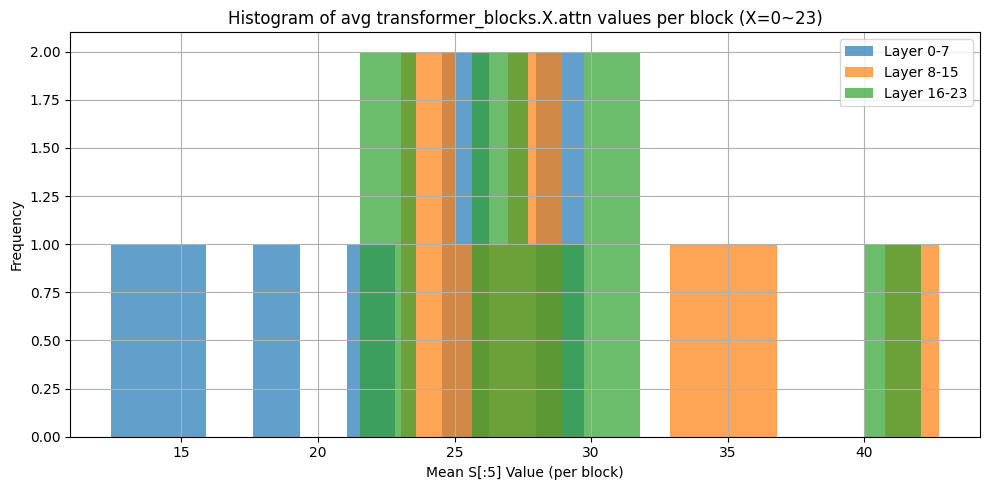

In [26]:
state_dict = torch.load("/home/u5649209/workspace/Diffusion_One/named_grads/{}_svd.pt".format(str(init_number)))
block_avg_values = []

# 对 transformer_blocks.0.attn ~ transformer_blocks.23.attn 分别处理
for i in range(24):
    prefix = f"transformer_blocks.{i}.attn"
    values = []
    for key, value in state_dict.items():
        if key.startswith(prefix):
            val = value["S"][:5].mean().item()
            values.append(val)
    if values:
        block_avg = np.mean(values)
        block_avg_values.append(block_avg)
    else:
        block_avg_values.append(np.nan)  # 没找到时占位

# 按三个段落分组
attn_groups = {
    "0-7": block_avg_values[0:8],
    "8-15": block_avg_values[8:16],
    "16-23": block_avg_values[16:24],
}

# 高区分度配色
colors = {
    "0-7": "#1f77b4",    # 蓝色
    "8-15": "#ff7f0e",   # 橙色
    "16-23": "#2ca02c",  # 绿色
}

# 绘图
plt.figure(figsize=(10, 5))
for group, values in attn_groups.items():
    plt.hist(values, bins=10, alpha=0.7, label=f"Layer {group}", color=colors[group])

plt.title("Histogram of avg transformer_blocks.X.attn values per block (X=0~23)")
plt.xlabel("Mean S[:5] Value (per block)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/home/u5649209/workspace/Diffusion_One/imgs/{}_depth.png".format(str(init_number)))
plt.show()

## Generate 12 bars or 12 plts

<Figure size 1000x500 with 0 Axes>

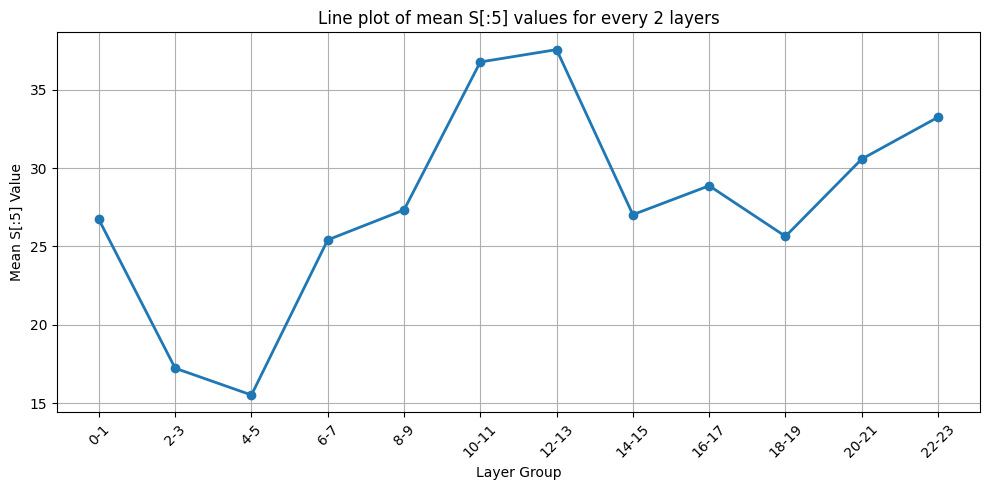

In [43]:
state_dict = torch.load("/home/u5649209/workspace/Diffusion_One/named_grads/{}_svd.pt".format(str(init_number)))
# 每个block的平均值（长度为24）
block_avg_values = []

for i in range(24):
    prefix = f"transformer_blocks.{i}.attn"
    values = []
    for key, value in state_dict.items():
        if key.startswith(prefix):
            val = value["S"][:5].mean().item()
            values.append(val)
    if values:
        block_avg = np.mean(values)
        block_avg_values.append(block_avg)
    else:
        block_avg_values.append(np.nan)  # 占位

# === 每两个 layer 合并求平均，生成12个bar ===
bar_means = []
bar_labels = []

for i in range(0, 24, 2):
    mean_val = np.nanmean([block_avg_values[i], block_avg_values[i+1]])
    bar_means.append(mean_val)
    bar_labels.append(f"{i}-{i+1}")

# === 绘制柱状图 ===
plt.figure(figsize=(10, 5))
# # Bar figure
# plt.bar(bar_labels, bar_means, color="#1f77b4", edgecolor="black")

# plt.title("Bar plot of mean S[:5] values for every 2 layers")
# plt.xlabel("Layer Groups")
# plt.ylabel("Mean S[:5] Value")
# plt.grid(True, axis='y')
# plt.tight_layout()


# 折线图
plt.figure(figsize=(10, 5))
plt.plot(range(len(bar_means)), bar_means, marker='o', color="#1f77b4", linewidth=2)
plt.xticks(ticks=range(len(bar_labels)), labels=bar_labels, rotation=45)
plt.title("Line plot of mean S[:5] values for every 2 layers")
plt.xlabel("Layer Group")
plt.ylabel("Mean S[:5] Value")
plt.grid(True)
plt.tight_layout()

plt.savefig("/home/u5649209/workspace/Diffusion_One/imgs/{}_depth_plt.png".format(str(init_number)))
plt.show()

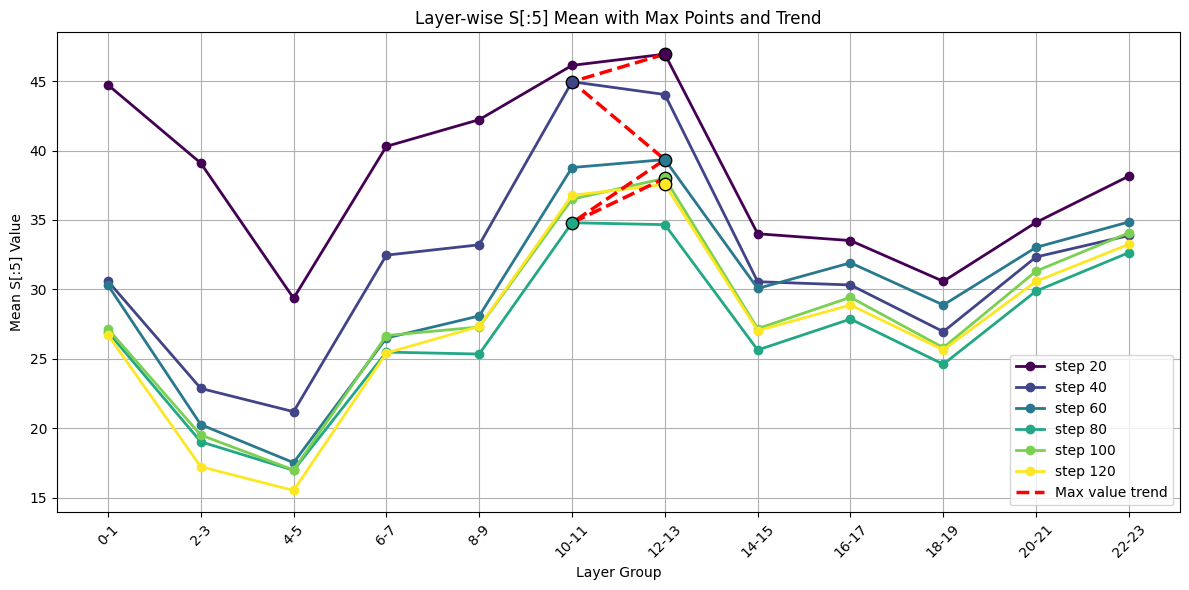

In [47]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 设置文件路径和step范围
steps = list(range(20, 121, 20))
base_path = "/home/u5649209/workspace/Diffusion_One/named_grads/"

# 存储每个step的折线值（每两个layer一组）
all_curves = {}
max_points = []  # (x_index, y_value, step) for trend line

for step in steps:
    filename = f"{base_path}{step}_svd.pt"
    try:
        state_dict = torch.load(filename)

        block_avg_values = []
        for i in range(24):
            prefix = f"transformer_blocks.{i}.attn"
            values = []
            for key, value in state_dict.items():
                if key.startswith(prefix):
                    val = value["S"][:5].mean().item()
                    values.append(val)
            if values:
                block_avg = np.mean(values)
                block_avg_values.append(block_avg)
            else:
                block_avg_values.append(np.nan)

        # 每两个layer合并求均值
        line_means = []
        for i in range(0, 24, 2):
            mean_val = np.nanmean([block_avg_values[i], block_avg_values[i + 1]])
            line_means.append(mean_val)

        all_curves[step] = line_means

        # 找最大值的位置
        max_idx = int(np.nanargmax(line_means))
        max_val = line_means[max_idx]
        max_points.append((max_idx, max_val, step))

    except Exception as e:
        print(f"Failed to load {filename}: {e}")

# 横轴 label
x_ticks = [f"{i}-{i+1}" for i in range(0, 24, 2)]

# 开始画图
plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(all_curves)))

# 画每条step曲线 + 最大值点
for (step, curve), color in zip(all_curves.items(), colors):
    plt.plot(range(len(curve)), curve, marker='o', label=f"step {step}", linewidth=2, color=color)
    # 标出最大值点
    max_idx = int(np.nanargmax(curve))
    max_val = curve[max_idx]
    plt.scatter(max_idx, max_val, color=color, s=80, edgecolors='black', zorder=5)

# 加一条最大值趋势线（按step顺序）
max_x = [pt[0] for pt in max_points]
max_y = [pt[1] for pt in max_points]
plt.plot(max_x, max_y, linestyle='--', color='red', linewidth=2.5, label="Max value trend")

# 标注和装饰
plt.xticks(ticks=range(len(x_ticks)), labels=x_ticks, rotation=45)
plt.title("Layer-wise S[:5] Mean with Max Points and Trend")
plt.xlabel("Layer Group")
plt.ylabel("Mean S[:5] Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"{base_path}/attn_lineplot_with_max_trend.png")
plt.show()


## Generate Modules


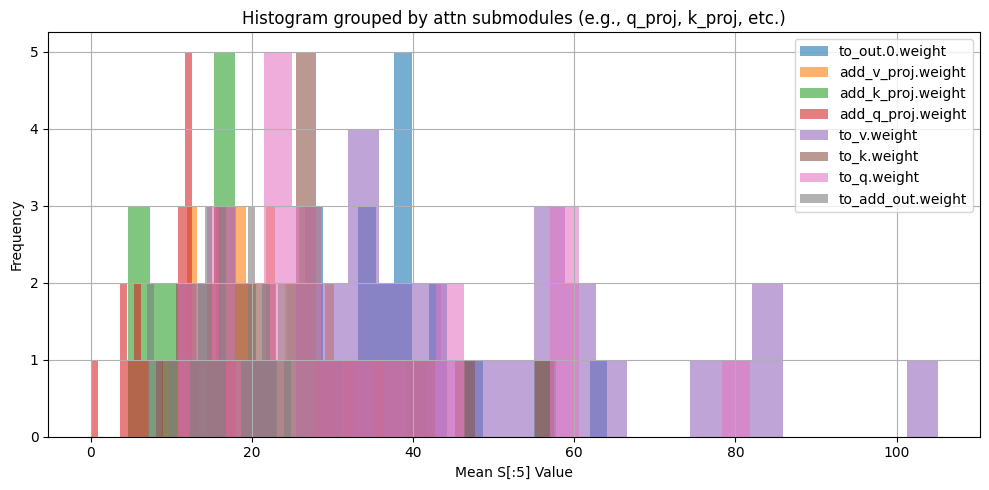

In [27]:
# 用后缀分组，例如 'q_proj', 'k_proj', 'out_proj'
state_dict = torch.load("/home/u5649209/workspace/Diffusion_One/named_grads/{}_svd.pt".format(str(init_number)))
suffix_groups = defaultdict(list)

for key, value in state_dict.items():
    if key.startswith("transformer_blocks.") and ".attn." in key:
        try:
            # 解析 key 的后缀：transformer_blocks.{i}.attn.{suffix}
            suffix = key.split(".attn.")[-1]
            val = value["S"][:5].mean().item()
            suffix_groups[suffix].append(val)
        except Exception as e:
            print(f"Warning: failed to process key {key}: {e}")

# 定义高区分度颜色
import itertools
color_cycle = itertools.cycle([
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
    "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
    "#bcbd22", "#17becf"
])

# 画直方图
plt.figure(figsize=(10, 5))
for suffix, values in suffix_groups.items():
    plt.hist(values, bins=20, alpha=0.6, label=suffix, color=next(color_cycle))

plt.title("Histogram grouped by attn submodules (e.g., q_proj, k_proj, etc.)")
plt.xlabel("Mean S[:5] Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/home/u5649209/workspace/Diffusion_One/imgs/{}_suffix.png".format(str(init_number)))
plt.show()